# News Headline Sarcasm Detection Project

By: Aditya Iyer, David Setrakyan, Minxi Lin, Zimeng Yang

## Overview

In this project, we aim to detect the sarcasm in news headlines using natural language processing. The dataset *News Headlines Dataset For Sarcasm Detection* was obtained from [Kaggle](https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection), which consists of headlines from *The Onion* (sarcastic) and *HuffPost* (not sarcastic).

## Data Description

The dataset includes headlines labeled as sarcastic (1) and non-sarcastic (0). They are obtained from *The Onion* and *HuffPost* and are written in English. Since the news headlines are written in formal style, they do not contain spelling errors or informal language. The dataset has 28619 observations and 3 variables: *is_sarcastic*, a binary variable indicating sarcasm, *headline*, the news headlines, and *article_link*, linking to the news articles for complementary information. 

## Methodologies

## Load and Clean the Dataset
### Load packages and the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import string
import missingno as msno
from collections import Counter
import re
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.util import bigrams

In [2]:
import json

def parse_data(file):
    for l in open(file, 'r'):
        yield json.loads(l)

data = list(parse_data('../data/Sarcasm_Headlines_Dataset_v2.json'))
df = pd.DataFrame(data)

### Data Information

In [3]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB
None


There are a total of 28619 rows and 3 columns in the dataset. *is_sarcastic* is a binary variable consisting of 0 and 1. *headline* and *article_link* are strings.

### Data Cleaning

#### Missing and duplicated data

<Axes: >

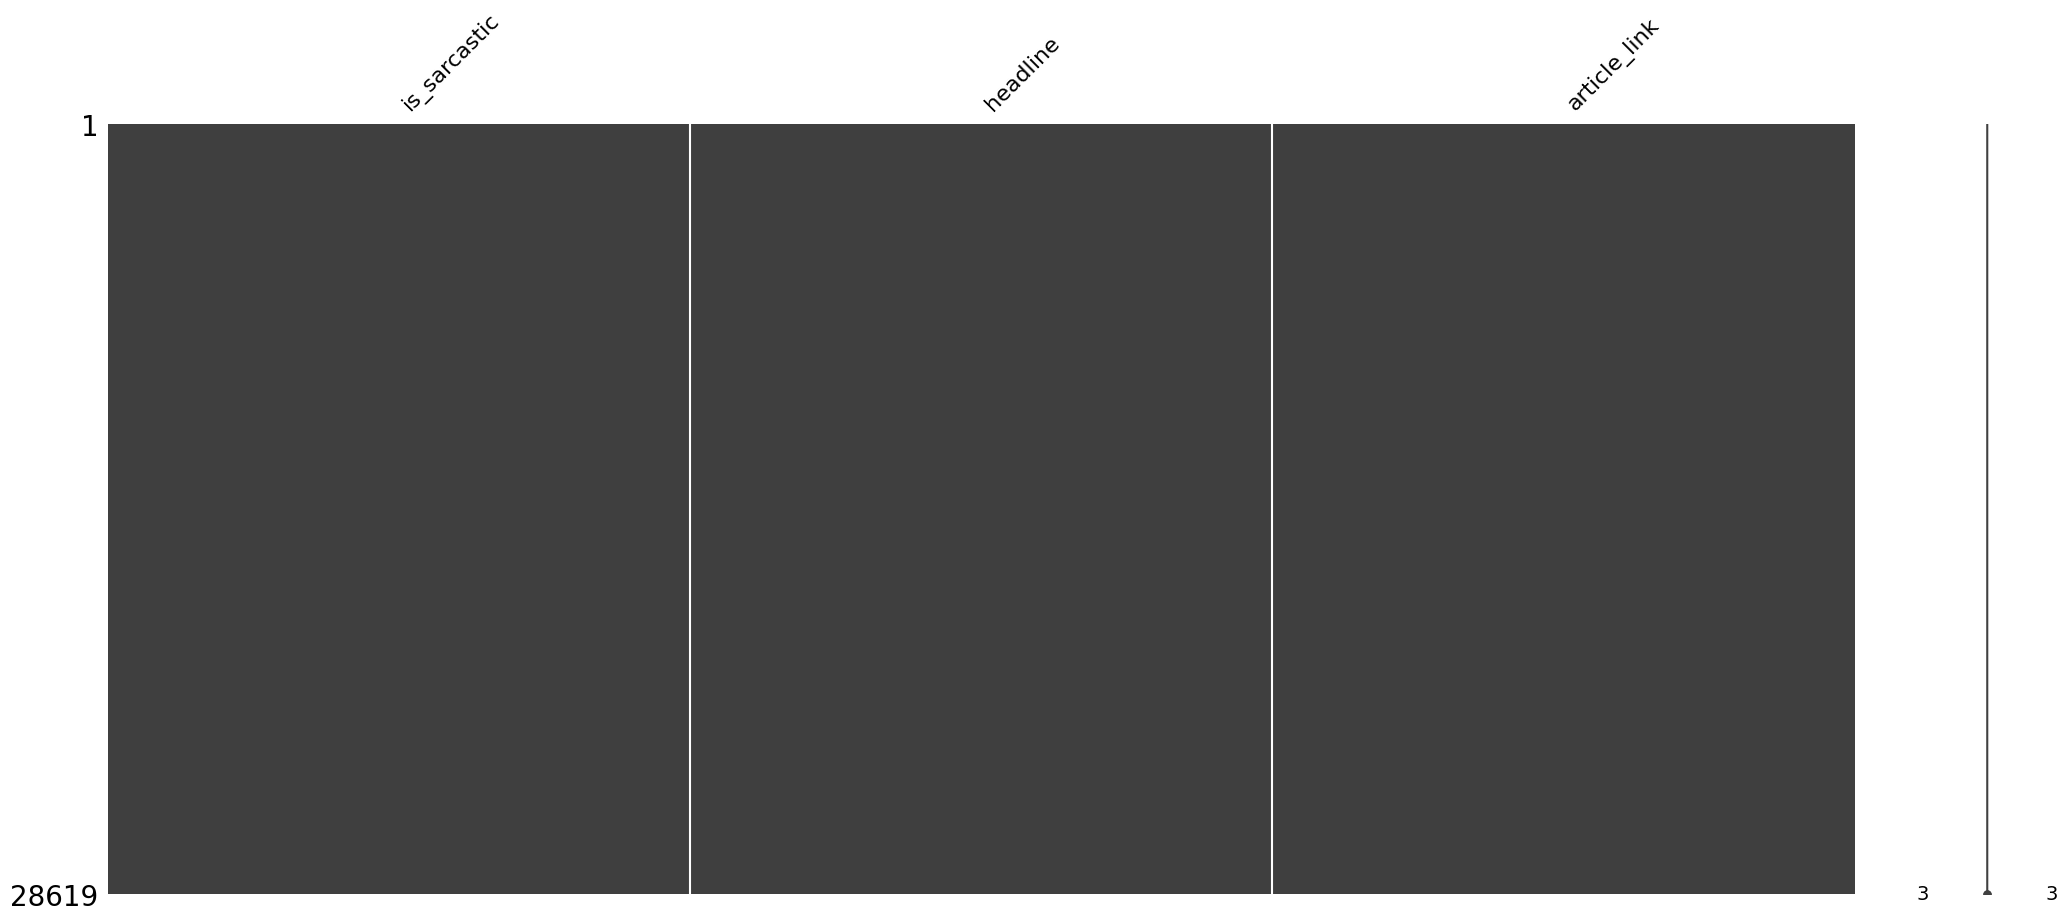

In [5]:
msno.matrix(df)

There is no missing data.

In [6]:
print(df[df.duplicated(keep = False)])
df = df[df.duplicated(keep='first') == False]

       is_sarcastic                                           headline  \
646               0                        hillary clinton vs. herself   
14897             1  nation not sure how many ex-trump staffers it ...   
18572             0                        hillary clinton vs. herself   
25743             1  nation not sure how many ex-trump staffers it ...   

                                            article_link  
646    https://www.huffingtonpost.comhttp://nymag.com...  
14897  https://politics.theonion.com/nation-not-sure-...  
18572  https://www.huffingtonpost.comhttp://nymag.com...  
25743  https://politics.theonion.com/nation-not-sure-...  


There are two duplicated rows in the dataset, so we will remove them.

#### Tokenization and removing stopwords

In [7]:
translator = str.maketrans('', '', string.punctuation)
df['headline'] = df['headline'].astype(str).str.lower() # convert headlines into lowercase
df['headline'] = df['headline'].apply(lambda x: x.translate(translator)) # remove punctuations
df['token'] = df.apply(lambda row: word_tokenize(row['headline']), axis=1) # tokenization
stop_words = set(stopwords.words('english'))
df['word'] = df['token'].apply(lambda x: [word for word in x if word not in stop_words]) # remove stopwords
df['bigram'] = df['token'].apply(lambda x: list(bigrams(x))) # bigrams
df['bigram_remove'] = df['bigram'].apply(lambda x: [word for word in x if word[0] not in stop_words 
                                                    and word[1] not in stop_words]) # remove bigrams with stop words
df['bigram'] = df['bigram_remove'].apply(lambda x: [' '.join(word) for word in x])
df.drop('bigram_remove', axis=1, inplace=True)

### Exploratory Data Analysis

#### Sarcastic v.s. non-sarcastic headlines distributions

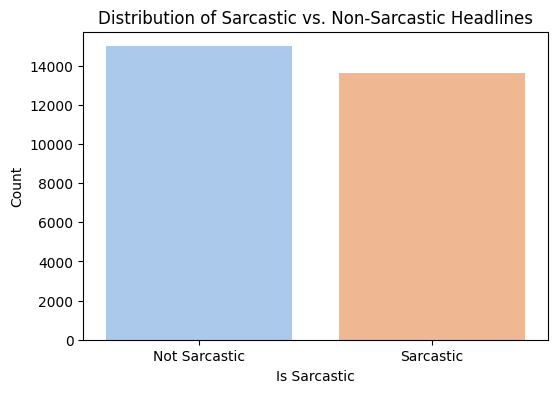

is_sarcastic
0    14984
1    13633
Name: count, dtype: int64 

is_sarcastic
0    0.523605
1    0.476395
Name: proportion, dtype: float64


In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="is_sarcastic", hue="is_sarcastic", palette="pastel", legend=False)
plt.title("Distribution of Sarcastic vs. Non-Sarcastic Headlines")
plt.xlabel("Is Sarcastic")
plt.ylabel("Count")
plt.xticks([0, 1], ["Not Sarcastic", "Sarcastic"])
plt.show()

print(df['is_sarcastic'].value_counts(), "\n")
print(df['is_sarcastic'].value_counts(normalize=True))

The two classes are almost balanced, where the number of non-sarcastic headlines is slightly higher. "Not sarcastic" class has approximately 15000 values and "sarcastic" class has approximately 13500 values.

#### Headline length distributions

In [9]:
df = df.assign(headline_length=df['headline'].apply(lambda x: len(x.split())))
df.head()

,is_sarcastic,headline,article_link,token,word,bigram,headline_length
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,"[thirtysomething, scientists, unveil, doomsday...","[thirtysomething, scientists, unveil, doomsday...","[thirtysomething scientists, scientists unveil...",8
1,0,dem rep totally nails why congress is falling ...,https://www.huffingtonpost.com/entry/donna-edw...,"[dem, rep, totally, nails, why, congress, is, ...","[dem, rep, totally, nails, congress, falling, ...","[dem rep, rep totally, totally nails, falling ...",13
2,0,eat your veggies 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,"[eat, your, veggies, 9, deliciously, different...","[eat, veggies, 9, deliciously, different, reci...","[veggies 9, 9 deliciously, deliciously differe...",7
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,"[inclement, weather, prevents, liar, from, get...","[inclement, weather, prevents, liar, getting, ...","[inclement weather, weather prevents, prevents...",8
4,1,mother comes pretty close to using word stream...,https://www.theonion.com/mother-comes-pretty-c...,"[mother, comes, pretty, close, to, using, word...","[mother, comes, pretty, close, using, word, st...","[mother comes, comes pretty, pretty close, usi...",9


In [10]:
print("The minimum of the headline length is", df['headline_length'].min())
print("\nThe maximum of the headline length is", df['headline_length'].max())
print("\nThe mean and median of the headline length are",round(df['headline_length'].mean(), 2), "and", df['headline_length'].median())

The minimum of the headline length is 2

The maximum of the headline length is 151

The mean and median of the headline length are 10.04 and 10.0


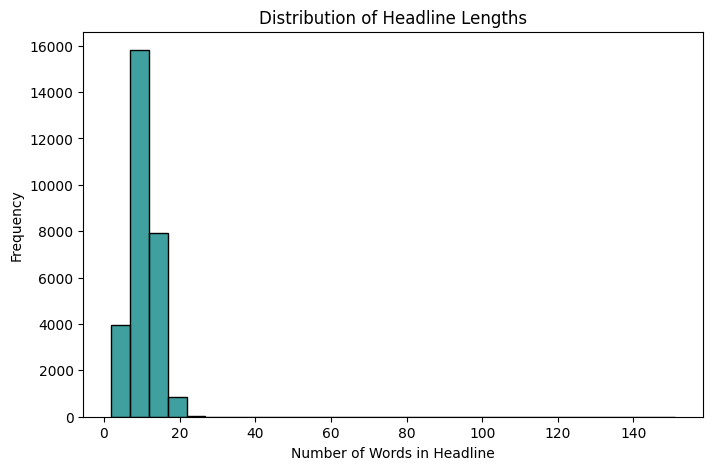

In [11]:
plt.figure(figsize=(8, 5))
sns.histplot(df['headline_length'], bins=30, kde=False, color="teal")
plt.title("Distribution of Headline Lengths")
plt.xlabel("Number of Words in Headline")
plt.ylabel("Frequency")
plt.show()

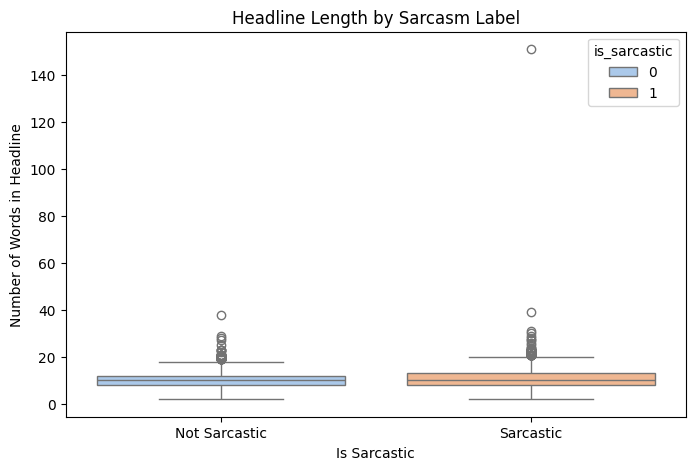

In [12]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['is_sarcastic'], hue = df['is_sarcastic'], y=df['headline_length'], palette="pastel")
plt.title("Headline Length by Sarcasm Label")
plt.xlabel("Is Sarcastic")
plt.ylabel("Number of Words in Headline")
plt.xticks([0,1], ["Not Sarcastic", "Sarcastic"])
plt.show()

In [14]:
print("Non-sarcastic headline length:")
print("\nThe minimum of the headline length is", df[df['is_sarcastic'] == 0]['headline_length'].min())
print("\nThe maximum of the headline length is", df[df['is_sarcastic'] == 0]['headline_length'].max())
print("\nThe mean and median of the headline length are",
      round(df[df['is_sarcastic'] == 0]['headline_length'].mean(), 2), "and", 
      df[df['is_sarcastic'] == 0]['headline_length'].median(),"\n\n")
print("sarcastic headline length:")
print("\nThe minimum of the headline length is", df[df['is_sarcastic'] == 1]['headline_length'].min())
print("\nThe maximum of the headline length is", df[df['is_sarcastic'] == 1]['headline_length'].max())
print("\nThe mean and median of the headline length are",
      round(df[df['is_sarcastic'] == 1]['headline_length'].mean(), 2), "and", 
      df[df['is_sarcastic'] == 1]['headline_length'].median(),"\n")

Non-sarcastic headline length:

The minimum of the headline length is 2

The maximum of the headline length is 38

The mean and median of the headline length are 9.8 and 10.0 


sarcastic headline length:

The minimum of the headline length is 2

The maximum of the headline length is 151

The mean and median of the headline length are 10.3 and 10.0 



The headline length distributions for both classes are similar and are heavily right skewed. The overall headline lengths range from 2 to 151 words and most of them are between 5 and 20 words. 

For non-sarcastic headlines, the length ranges from 2 to 38 words, and the average length is 9.8 words. For sarcastic headlines, the length ranges from 2 to 151 words, and the average length is 10.3 words. The median of both classes are 10.

#### Most commonly-occurring words and bigrams

In [24]:
# create a dataframe of words & count broken by is_sarcastic
words_1 = [] # sarcastic word
bigram_1 = [] # sarcastic bigram
words_0 = [] # not sarcastic
bigram_0 = [] # sarcastic bigram

for index, row in df.iterrows():
    if row['is_sarcastic'] == 1:
        for w in row['word']:
            words_1.append(w)
        for b in row['bigram']:
            bigram_1.append(b)
    elif row['is_sarcastic'] == 0:
        for w in row['word']:
            words_0.append(w)
        for b in row['bigram']:
            bigram_0.append(b)

count_1 = Counter(words_1)
words_1_df = pd.DataFrame(count_1.items(), columns = ['word', 'count'])
words_1_df = words_1_df.sort_values(by = 'count', ascending = False) # sarcastic word df
count_0 = Counter(words_0)
words_0_df = pd.DataFrame(count_0.items(), columns = ['word', 'count'])
words_0_df = words_0_df.sort_values(by = 'count', ascending = False) # not sarcastic word df

count_b_1 = Counter(bigram_1)
bigram_1_df = pd.DataFrame(count_b_1.items(), columns = ['bigram', 'count'])
bigram_1_df = bigram_1_df.sort_values(by = 'count', ascending = False) # sarcastic bigram df
count_b_0 = Counter(bigram_0)
bigram_0_df = pd.DataFrame(count_b_0.items(), columns = ['bigram', 'count'])
bigram_0_df = bigram_0_df.sort_values(by = 'count', ascending = False) # not sarcastic bigram df

In [15]:
# create a dataframe of words & counts
all_words = [word for i in df['word'] for word in i]
count = Counter(all_words)
word_count_df = pd.DataFrame(count.items(), columns = ['word', 'count'])
word_count_df = word_count_df.sort_values(by = 'count', ascending = False)

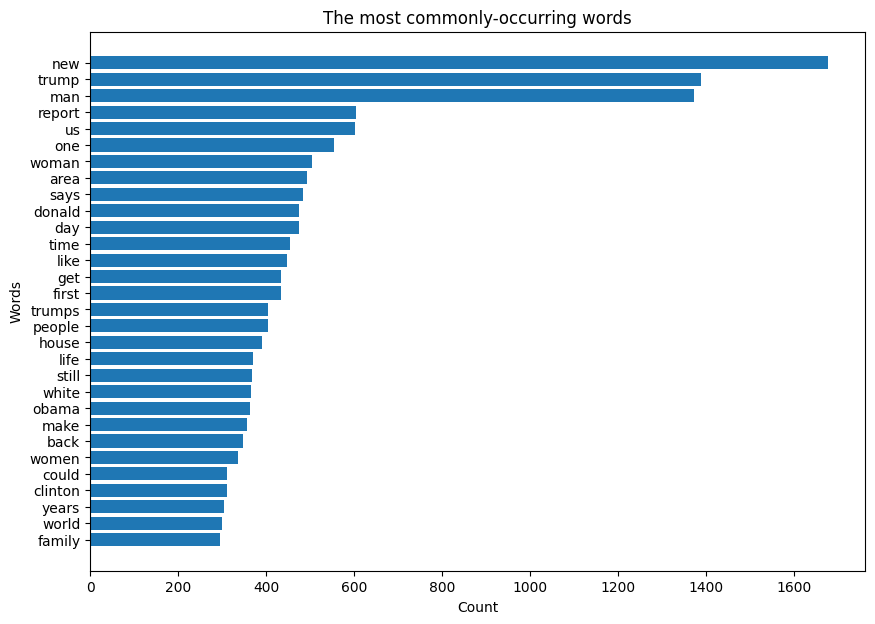

In [17]:
# the most commonly-occurring words
common_word = word_count_df[:30]
plt.figure(figsize=(10,7))
plt.barh(common_word['word'], common_word['count'])
plt.title("The most commonly-occurring words")
plt.xlabel("Count")
plt.ylabel("Words")
plt.gca().invert_yaxis()
plt.show()

The five most commonly-occurring words are "new," "trump," "man," "report," and "us," and the frequencies of the first three words are significantly greater than the other words.

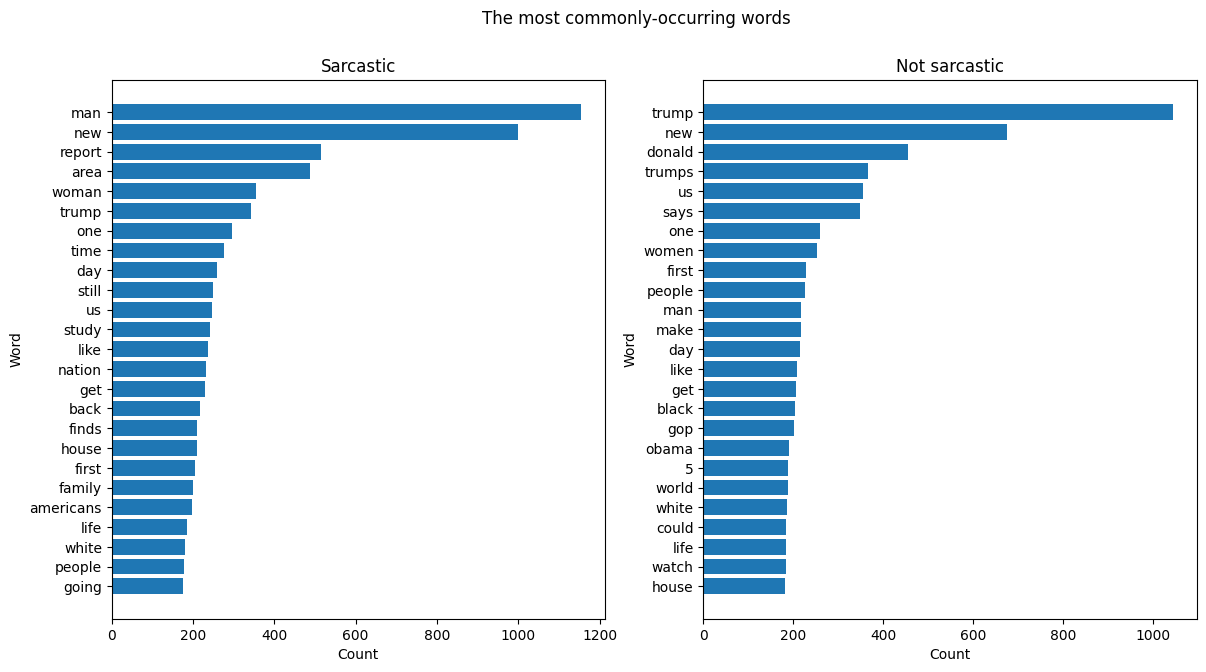

In [25]:
# the most commonly-occurring words, broken down by label
common_words_1 = words_1_df[:25]
common_words_0 = words_0_df[:25]
fig, axs = plt.subplots(1, 2)
fig.set_figheight(7)
fig.set_figwidth(14)
axs[0].barh(common_words_1['word'], common_words_1['count']) # positive
axs[0].invert_yaxis()
axs[0].set_xlabel("Count")
axs[0].set_ylabel("Word")
axs[1].barh(common_words_0['word'], common_words_0['count']) # negative
axs[1].invert_yaxis()
axs[1].set_xlabel("Count")
axs[1].set_ylabel("Word")
fig.suptitle("The most commonly-occurring words")
axs[0].title.set_text('Sarcastic')
axs[1].title.set_text('Not sarcastic')
plt.show()

The five most commonly-occurring words for sarcastic headlines are *man*, *new*, *report*, *area*, and *woman*. The five most commonly-occurring words for non-sarcastic headlines are *trump*, *new*, *donald*, *trumps*, and *us*. *New* occurs commonly in both categories, and non-sarcastic news headlines tend to mention words related to Donald Trump more often.

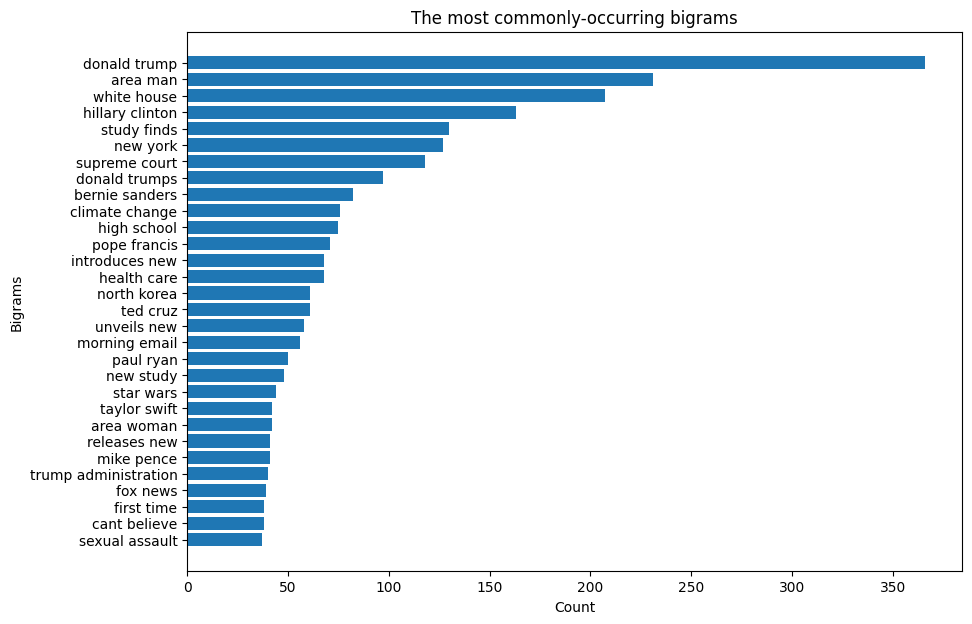

In [23]:
# create a dataframe of bigrams & counts
all_bigrams = [bigram for i in df['bigram'] for bigram in i]
count_bigram = Counter(all_bigrams)
bigram_count_df = pd.DataFrame(count_bigram.items(), columns = ['bigram', 'count'])
bigram_count_df = bigram_count_df.sort_values(by = 'count', ascending = False)

# the most commonly-occurring bigrams
common_bigram = bigram_count_df[:30]
plt.figure(figsize=(10,7))
plt.barh(common_bigram['bigram'], common_bigram['count'])
plt.title("The most commonly-occurring bigrams")
plt.xlabel("Count")
plt.ylabel("Bigrams")
plt.gca().invert_yaxis()
plt.show()

The five most commonly-occuring bigrams are *donald trump*, *area man*, *white house*, *hilary clinton*, and *study finds*, and *donald trump* occurs substantially more frequent than the other bigrams.

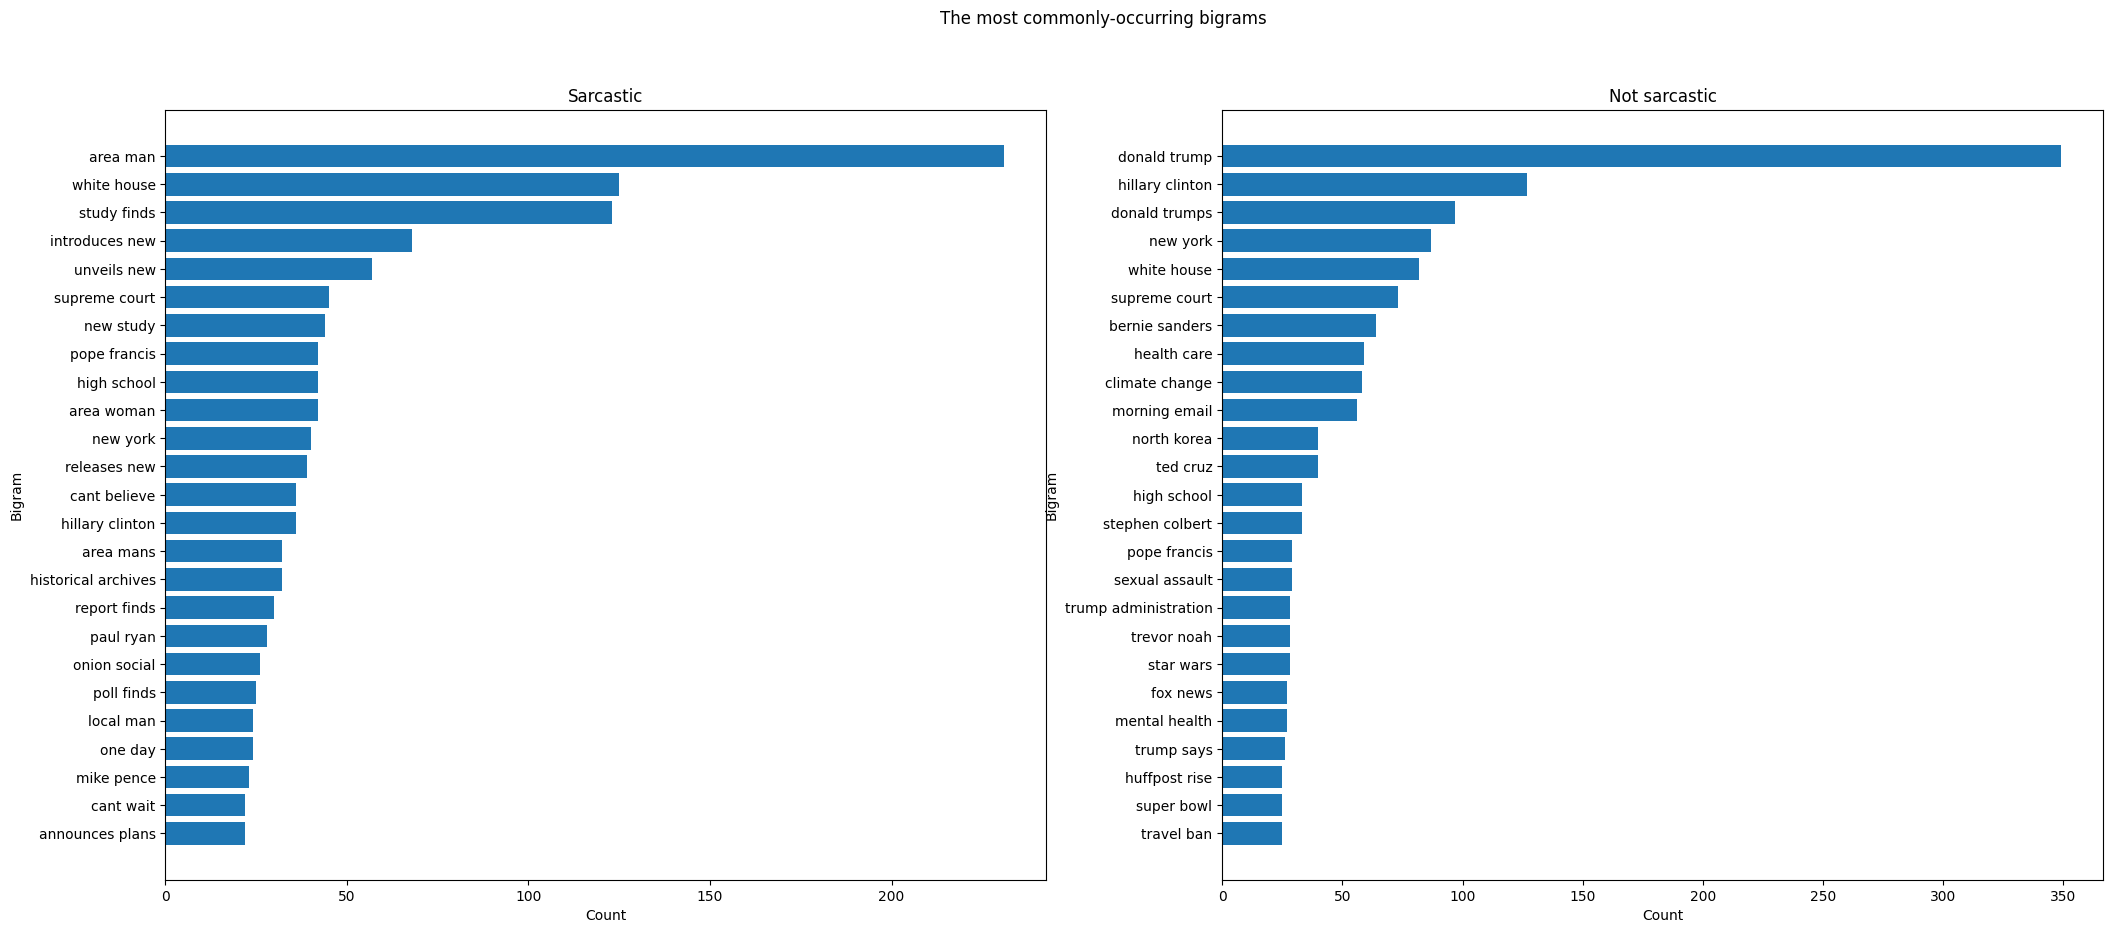

In [26]:
# the most commonly-occurring bigrams, broken down by label
common_bigram_1 = bigram_1_df[:25]
common_bigram_0 = bigram_0_df[:25]
fig, axs = plt.subplots(1, 2)
fig.set_figheight(10)
fig.set_figwidth(25)
axs[0].barh(common_bigram_1['bigram'], common_bigram_1['count']) # positive
axs[0].invert_yaxis()
axs[0].set_xlabel("Count")
axs[0].set_ylabel("Bigram")
axs[1].barh(common_bigram_0['bigram'], common_bigram_0['count']) # negative
axs[1].invert_yaxis()
axs[1].set_xlabel("Count")
axs[1].set_ylabel("Bigram")
fig.suptitle("The most commonly-occurring bigrams")
axs[0].title.set_text('Sarcastic')
axs[1].title.set_text('Not sarcastic')
plt.show()

The five most commonly-occurring bigrams for sarcastic headlines are *area man*, *white house*, *study finds*, *introduces new*, and *unveils new*. The five most commonly-occurring bigrams for non-sarcastic headlines are *donald trump*, *hilary clinton*, *donald trumps*, *new york*, and *white house*. The frequencies of *area man* and *donald trump* significantly outnumber the other bigrams separately in sarcastic and not sarcastic classes. It seems that the full names of celebrities are more likely to occur in non-sarcastic headlines.

#### Sentiment analysis of words

In [27]:
def sentiment(score):
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

In [33]:
# generate wordcloud based on sentiment
def generate_wordcloud(df, n_gram = "word", n = 60):
    # Word frequencies broken by sentiment
    count_positive = Counter(df[df['sentiment'] == 'positive'][n_gram])
    count_negative = Counter(df[df['sentiment'] == 'negative'][n_gram])
    count_positive_df = pd.DataFrame(count_positive.items(), columns = [n_gram, 'count'])
    count_negative_df = pd.DataFrame(count_negative.items(), columns = [n_gram, 'count'])
    # Differentiate by color
    count_positive_df['color'] = 'indianred'
    count_negative_df['color'] = 'royalblue'
    # Most common words
    common_positive_df = count_positive_df.nlargest(n, 'count')
    common_negative_df = count_negative_df.nlargest(n, 'count')
    # Combine dataframes; create dictionaries for frequency and color
    common_df = pd.concat([common_positive_df, common_negative_df])
    common_df_freq = dict(zip(common_df[n_gram], common_df['count']))
    common_df_color = dict(zip(common_df[n_gram], common_df['color']))
    wordcloud = WordCloud(width=800, height=800, 
                      background_color="white",
                      min_font_size = 10).generate_from_frequencies(common_df_freq)
    return wordcloud, common_df_color

In [29]:
# Sentiment of all words
sid_obj = SentimentIntensityAnalyzer()
all_words_df = pd.DataFrame({'word': all_words})
all_words_df['sentiment_score'] = all_words_df['word'].apply(lambda x: sid_obj.polarity_scores(x)['compound'])
all_words_df['sentiment'] = all_words_df['sentiment_score'].apply(lambda x: sentiment(x))

# Sentiment of words broken by is_sarcastic
words_1_df = pd.DataFrame({'word': words_1})
words_1_df['sentiment_score'] = words_1_df['word'].apply(lambda x: sid_obj.polarity_scores(x)['compound'])
words_1_df['sentiment'] = words_1_df['sentiment_score'].apply(lambda x: sentiment(x))

words_0_df = pd.DataFrame({'word': words_0})
words_0_df['sentiment_score'] = words_0_df['word'].apply(lambda x: sid_obj.polarity_scores(x)['compound'])
words_0_df['sentiment'] = words_0_df['sentiment_score'].apply(lambda x: sentiment(x))

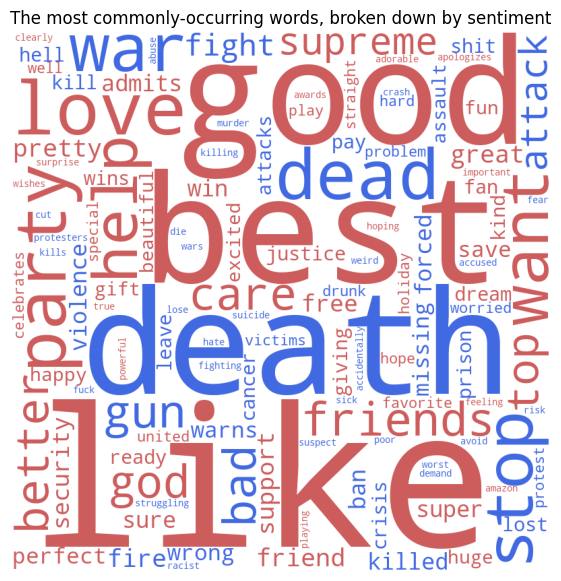

In [34]:
all_words_wc, all_words_color = generate_wordcloud(all_words_df)
plt.figure(figsize=(7, 7))
plt.imshow(all_words_wc.recolor(color_func=lambda word, **kwargs: all_words_color[word]))
plt.axis("off")
plt.title("The most commonly-occurring words, broken down by sentiment")
plt.show()

Words with positive sentiment are more common than these with negative sentiments. Most commonly-occurring words with positive sentiment are *like*, *good*, and *best*, and words with negative sentiment are *death*, *dead*, *war* and *stop*.

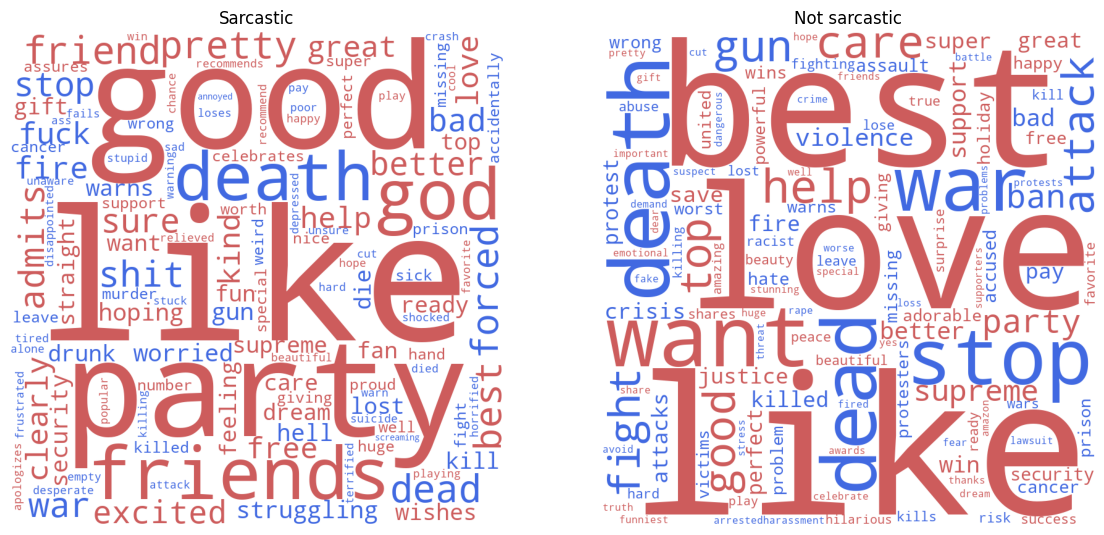

In [35]:
words_1_wc, words_1_color = generate_wordcloud(words_1_df)
words_0_wc, words_0_color = generate_wordcloud(words_0_df)
fig, axs = plt.subplots(1, 2)
fig.set_figheight(7)
fig.set_figwidth(14)
axs[0].imshow(words_1_wc.recolor(color_func=lambda word, **kwargs: words_1_color[word]))
axs[1].imshow(words_0_wc.recolor(color_func=lambda word, **kwargs: words_0_color[word]))
axs[0].title.set_text('Sarcastic')
axs[1].title.set_text('Not sarcastic')
axs[0].axis("off")
axs[1].axis("off")
plt.show()

Non-sarcastic headlines tend to have slightly more words with negative sentiments. *Like* and *death* are common in both categories.

For sarcastic sentiments, the most common words with positive sentiment are *good*, *like*, and *party*, and these with negative words are *death*, *dead*, and *forced*.

For non-sarcastic sentiments, the most common words with positive sentiment are *best*, *love*, and *like*, and these with negative words are *death*, *dead*, and *stop*.